# A Gaussian process implementation

This post explores some of the concepts behind Guassian processes such as stochastic processes and the kernel function. We will build up deeper understanding on how to implement Gaussian process regression from scratch on a toy example.

This post assumes familiarity with basic probability and linear algebra especially in the context of multivariate Gaussian distributions. Have a look at [this post]() if you need a refresher.

In [1]:
# Imports
%matplotlib notebook

import sys
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
np.random.seed(42)
#

What are Gaussian processes? The name implies that its a stochastic process of random variables with a Gaussian distribution. This might not mean much at this point so lets dig a bit deeper in its meaning:


## Stochastic process

[Stochastic processes](https://en.wikipedia.org/wiki/Stochastic_process) typically describe systems randomly changing over time. The processes are [stochastic](https://en.wikipedia.org/wiki/Stochastic) due to the uncertainty in the system. Even if the starting point is known, there are several directions in which the processes can evolve.

An example of a stochastic process that you might have come across is the model of [Brownian motion](https://en.wikipedia.org/wiki/Brownian_motion) (also known as [Wiener process](https://en.wikipedia.org/wiki/Wiener_process) ). Brownian motion is the random motion of particles suspended in a fluid. It can be seen as a continuous [random walk](https://en.wikipedia.org/wiki/Random_walk) where a particle moves around in the fluid due to other particles randomly bumping into it. We can simulate this process over time in 1 dimension by starting out at position 0 and move the particle over a certain amount of time $\Delta t$ with a random distance $\Delta d$ from the previous position. The random distance is sampled from a [normal distribution](https://en.wikipedia.org/wiki/Normal_distribution) with mean $0$ and variance $\Delta t$. Sampling $\Delta d$ from this normal distribution is noted as $\Delta d \sim \mathcal{N}(0, \Delta t)$. We simulate 5 different paths of brownian motion in the following figure, each path is illustrated with a different color.

<IPython.core.display.Javascript object>


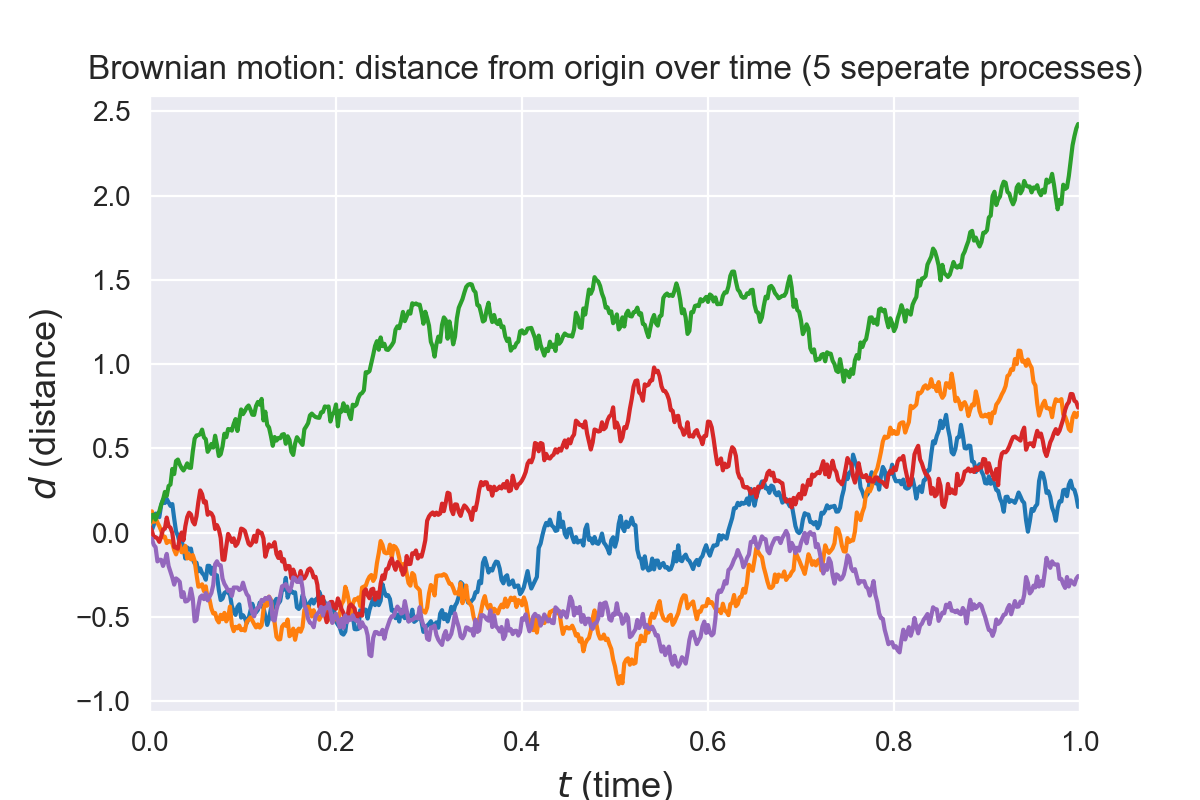

In [2]:
# 1D simulation of the Brownian motion process
total_time = 1
nb_steps = 500
delta_t = total_time / nb_steps
nb_processes = 5  # Simulate 5 different motions
mean = 0.  # Mean of each movement
stdev = np.sqrt(delta_t)  # Standard deviation of each movement

# Simulate the brownian motions in a 1D space by cumulatively
#  making a new movement delta_d
distances = np.cumsum(
    # Move randomly from current location to N(0, delta_t)
    np.random.normal(
        mean, stdev, (nb_processes, nb_steps)),
    axis=1)

plt.figure(figsize=(6, 4))
# Make the plots
t = np.arange(0, total_time, delta_t)
for i in range(nb_processes):
    plt.plot(t, distances[i,:])
plt.title((
    'Brownian motion: distance from origin over time '
    '(5 seperate processes)'))
plt.xlabel('$t$ (time)', fontsize=13)
plt.ylabel('$d$ (distance)', fontsize=13)
plt.xlim([-0, 1])
plt.show()
#

Notice in the figure above that the stochastic process can lead to different paths, also known as [realizations](https://en.wikipedia.org/wiki/Realization_%28probability%29) of the process.  Each realization defines a distance $d$ from the origin for every possible timestep $t$. Every realization thus corresponds to a function $f(t) = d$.

This means that a stochastic process can be interpreted as a random distribution over functions. We can sample a realization of a function from a stochastic process, however each realized function can be different due to the randomness of the stochastic process. Gaussian processes ($\mathcal{GP}$) are stochastic processes with specific underlying distributions.

## Gaussian process

So now we understand where the "process" in Guassian process comes from, but what makes it Gaussian? Lets compare it with the [Guassian distribution]({% post_url 2018-09-28-multivariate-normal-primer %}). A Gaussian distribution, also known as the normal distribution, is is fully specified by a mean vector, $\mu$, and covariance matrix $\Sigma$. We denote this normal distribution as $\mathcal{N}(\mathbf{\mu}, \Sigma)$.

A Guassian process is defined in a similar way, but instead of being defined by a mean vector and a covariance matrix it is defined by a mean function $m(x)$ and covariance function $C(x,x')$, with $x$ the [indepdentent variables](https://en.wikipedia.org/wiki/Dependent_and_independent_variables) and  $(x,x')$ all possible pairs in the input [domain](https://en.wikipedia.org/wiki/Domain_of_a_function). We denote the Guassian process distribution as: 

$$\mathcal{GP}(m(x),C(x,x'))$$

De biggest conceptual difference between the Gaussian distribution and the Gaussian process is that the [Gaussian distribution](https://en.wikipedia.org/wiki/Multivariate_normal_distribution) consists of a fixed number of random variables (or dimensions). The number of random variables of a multivariate Gaussian is determined by the dimensionality of the mean vector and the covariance matrix. The Gaussian process doesn't have this limitation, its mean and covariance are defined by a [function](https://en.wikipedia.org/wiki/Function_(mathematics)). Each input to this function is a random variable correlated with the other variables as defined by the covariance function. Since functions can take infinitely many different inputs, the Gaussian process can be viewed as an infinite dimensional Gaussian random variable.

Note for now that this means that every finite subset of a Gaussian Process is a Multivariate Gaussian.

## Sampling from the Gaussian process distribution

Since a Gaussian process is a distribution over functions we can sample function realizations $f$ from our distribution:

$$f(x) \sim \mathcal{GP}(m(x),C(x,x'))$$

With $f:\mathbb{R}^d \rightarrow \mathbb{R}$ and $x$ an imput example from the set of input data with dimension $d$. The mean $m(x)$ and covariance $C(x,x')$ are both a function of $x$:

$$m(x) = \mathbb{E}[f(x)]$$

$$C(x,x') = \mathbb{E}[(f(x)-m(x))(f(x')-m(x'))] $$


### Kernel function as prior

To sample functions from the Gaussian process we need to define the mean and covariance functions. The specification of this covariance function, also known as the kernel, implies a distribution over functions $f(x)$. By choosing a specific kernel function $K$ it possible to set [prior](https://en.wikipedia.org/wiki/Prior_probability) information on this distribution. 

In this post we will model the covariance with the [radial basis function](https://en.wikipedia.org/wiki/Radial_basis_function_kernel) (RBF) kernel:

$$K(x,x') = \exp{ \left( -\frac{1}{2\sigma^2} \lVert x-x' \rVert^2 \right)} $$

Using the RBF kernel will result in [smooth](https://en.wikipedia.org/wiki/Smoothness) functions sampled from the Gaussian process. Choosing different kernel functions will set different priors on the distribution. In what follows we will just take the zero function $m(x) = 0$ for the mean and set $\sigma=1$ for the RBF kernel.

In [3]:
# Define the RBF kernel
def rbf_kernel(xa, xb):
    """Radial Basis Function (RBF)"""
    # L2 distance (Squared Euclidian)
    sq_norm = -0.5 * scipy.spatial.distance.cdist(xa, xb, 'sqeuclidean')
    return np.exp(sq_norm)

### Sampling from prior

In practice we can't just sample a full function evaluation $f$ from a Gaussian process distribution with mean $m(x)=0$ and kernel $K(x,x')$ since that would mean evaluating $m(x)$ and $K(x,x')$ at an infinite number of points since $x$ can have a continuous [domain](https://en.wikipedia.org/wiki/Domain_of_a_function). We can however sample function evaluations $\mathbf{y}$ of a function $f$ from a Gaussian process at defined input points $X$: $f(X)=\mathbf{y}$.

To sample these function evaluations we can pick a number of input points $X$ and create the corresponding covariance matrix defined by $K(X,X)=K$. Taking a limited number of input samples and feeding them through the mean and covariance functions results into a mean vector and covariance matrix. Note that since $K$ is a matrix and the mean is a vector these define a [multivariate Gaussian]({% post_url 2018-09-28-multivariate-normal-primer %}) $\mathcal{N}(0,K)$. Thus we can sample the function evaluations from this finite distribution: $f(X)=\mathbf{y} \sim \mathcal{N}(0,K)$. Notice that a finite subset of the independent variables of a Gaussian process results into a multivariate Guassian distribution.


#### Sample from multivariate Gaussian distribution

We can [sample from a multivariate Gaussian distribution]({% post_url 2018-09-28-multivariate-normal-primer %}#Sampling-from-a-multivariate-normal) with the help of the [Cholesky decomposition](https://en.wikipedia.org/wiki/Cholesky_decomposition) $K = L L^\top$.  
To sample from $\mathcal{N}(0,K)$ we can sample from the standard normal distribution $\mathcal{N}(0, I_d)$ and [transform the results]({% post_url 2018-09-28-multivariate-normal-primer %}) with $L$:

$$\mathbf{y} \sim L\mathcal{N}(0,I_d)$$ 

We illustrate this below by sampling at discrete points from $\mathcal{N}(0,I_d)$ and taking the dot product of this with $L$. We sample discrete points from 5 functions, each function in a different color. Note that each of them is smooth since the RBF kernel function acts as a smoothness prior.

It might be needed to add a small constant to the kernel matrix's diagonal to ensure it's positive definite in order to calculate the Cholesky decomposition. The kernel matrix should be [positive definite](https://en.wikipedia.org/wiki/Positive-definite_matrix), but might not be because of [numerical precision](https://en.wikipedia.org/wiki/Precision_%28computer_science%29).

In [4]:
# Sample from the Gaussian process distribution
nb_of_samples = 100  # Number of points in each function
number_of_functions = 5  # Number of functions to sample
# Independent variable samples
X = np.expand_dims(np.linspace(-4, 4, nb_of_samples), 1)
K = rbf_kernel(X, X)  # Kernel of data points

# Small constant to ensure positive definite kernel
constant = 1e-6 * np.eye(nb_of_samples)

# Draw samples from the prior at our data points.
L = np.linalg.cholesky(K + constant)
std_normal = np.random.normal(
    size=(nb_of_samples, number_of_functions))
y = L @ std_normal

<IPython.core.display.Javascript object>


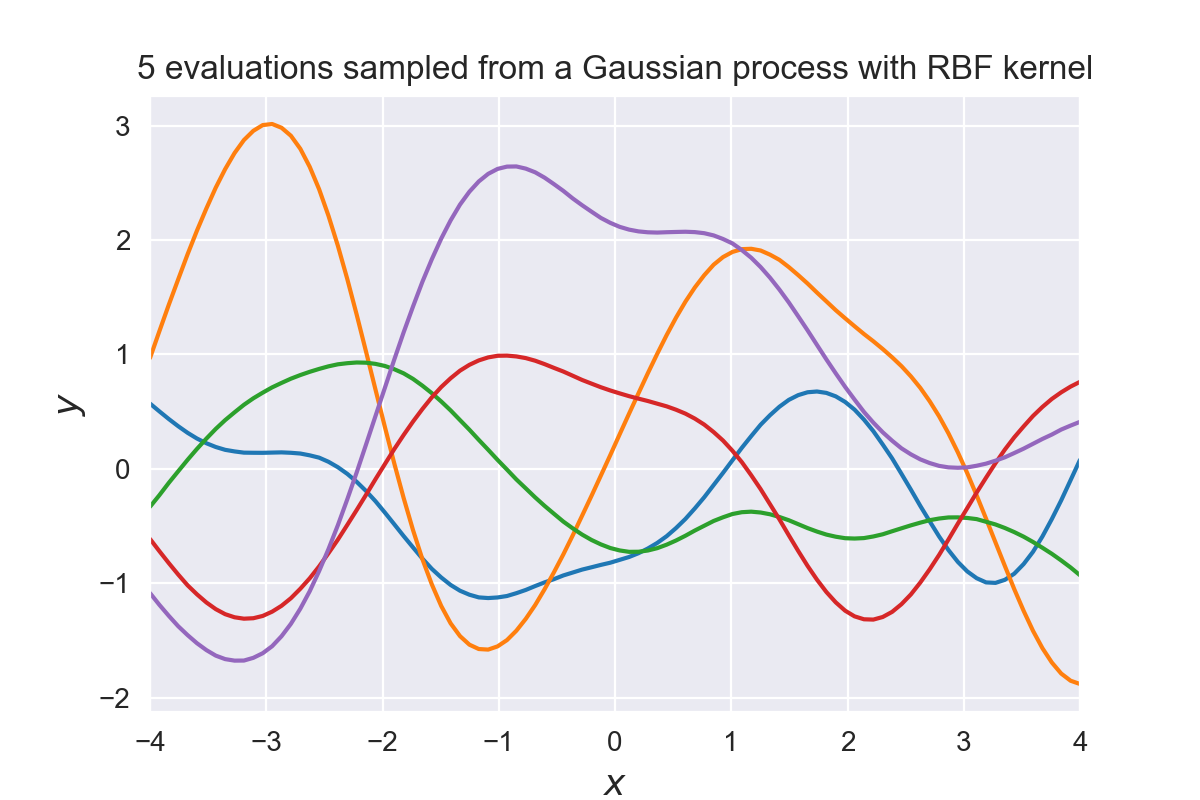

In [15]:
# Plot the sampled functions
plt.figure(figsize=(6, 4))
plt.plot(X, y)
plt.xlabel('$x$', fontsize=13)
plt.ylabel('$y$', fontsize=13)
plt.title(
    '5 evaluations sampled from a Gaussian process with RBF kernel')
plt.xlim([-4, 4])
plt.show()
#

## Gaussian processes for regression

Since Gaussian processes model functions over distributions we can use them to build [regression](https://en.wikipedia.org/wiki/Regression_analysis) models. We can treat the Gaussian process as a prior defined by the kernel function and create a [posterior distribution](https://en.wikipedia.org/wiki/Posterior_probability) given some data. This posterior distribution can then be used to predict the output variable $\mathbf{y}$ given input variables $X$.


### Predictions from posterior

We want to make predictions $\mathbf{y}_2 = f(X_2)$ for $n_2$ new samples, and we want to make these predictions based on our Gaussian process prior and $n_1$ previously observed data points $(X_1,\mathbf{y}_1)$. This can be done with the help of the posterior distribution $p(\mathbf{y}_2 \mid X_2,X_1,\mathbf{y}_1)$. $\mathbf{y}_1$ and $\mathbf{y}_2$ are [jointly Gaussian](https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Joint_normality) since they should come both from the same function. Since they are jointly Gaussian and we have a finite number of samples we can write: 

$$
\left[\begin{array}{c} \mathbf{y}_{1} \\ \mathbf{y}_{2} \end{array}\right]
\sim
\mathcal{N} \left(
\left[\begin{array}{c} \mu_{1} \\ \mu_{2} \end{array}\right]
\left[ \begin{array}{cc}
K_{11} & K_{12} \\
K_{21} & K_{22}
\end{array} \right]
\right)
$$

Where:
$$\begin{split}
\mu_{1} & = m(X_1) \quad (n_1 \times 1) \\
\mu_{2} & = m(X_2) \quad (n_2 \times 1) \\
K_{11} & = K(X_1,X_1) \quad (n_1 \times n_1) \\
K_{22} & = K(X_2,X_2) \quad (n_2 \times n_2) \\
K_{12} & = K(X_1,X_2) = K_{21}^\top \quad (n_1 \times n_2)
\end{split}$$

Note that $K_{11}$ is independent of $K_{22}$ and vice versa.

We can then get the [conditional distribution]({% post_url 2018-09-28-multivariate-normal-primer %}#Conditional-distribution):

$$\begin{split}
p(y_2 \mid X_2, X_1, y_1) & =  \mathcal{N}(\mu_{2|1}, \Sigma_{2|1}) \\
\mu_{2|1} & = \mu_2 + K_{21} K_{11}^{-1} (\mathbf{y}_1 - \mu_1) \\
          & = K_{21} K_{11}^{-1} \mathbf{y}_1 \quad (\text{assume mean prior }  \mu = 0 ) \\
\Sigma_{2|1} & =  K_{22} - K_{21} K_{11}^{-1}K_{12}
\end{split}$$

We can write these as:

$$\begin{array}{cc}
\begin{split}
\mu_{2|1} & = K_{21} K_{11}^{-1} \mathbf{y}_1 \\
          & = (K_{11}^{-1} K_{12})^{\top}  \mathbf{y}_1 \\
\end{split}
& \qquad
\begin{split}
\Sigma_{2|1} & = K_{22} - K_{21} K_{11}^{-1} K_{12} \\
             & = K_{22} - (K_{11}^{-1} K_{12})^{\top} K_{12} \\
\end{split}
\end{array}$$

Which means we can compute the $K_{11}^{-1} K_{12}$ term with the help of Scipy's [`solve`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.solve.html) function which solves for $x$ the [linear system](https://en.wikipedia.org/wiki/System_of_linear_equations) $K_{11} \cdot x = K_{12}$. Using this method [improves](https://www.johndcook.com/blog/2010/01/19/dont-invert-that-matrix/) the speed and numerical accuracy compared to computing the inverse of $K_{11}$ directly. Especially since it can make use of the fact that $K_{11}$ is [symmetric and positive definite](https://en.wikipedia.org/wiki/Cholesky_decomposition#Applications). Note that $K_{11} = K_{11}^{\top}$ since it's [symmetric](https://en.wikipedia.org/wiki/Symmetric_matrix).

It is then possible to predict $\mathbf{y}_2$ corresponding to the input samples $X_2$ by using the mean $\mu_{2|1}$ of the resulting distribution as a prediction. 
Notice that the mean of the posterior predictions $\mu_{2|1}$ of a Gaussian process are weighted averages of the observed variables $\mathbf{y}_1$, where the weighting is based on the coveriance function $K$. The variance $\sigma_2^2$ of these predictions is then the diagonal of the covariance matrix $\Sigma_{2|1}$.

In [6]:
# Gaussian process posterior
def GP(X1, y1, X2, kernel_func):
    """
    Calculate the mean and covariance matrix for the points 
    X2 with unknown y2, based on the observations (y1, X1) 
    and the prior kernel function.
    """
    # Kernel of the observations with constant to ensure 
    #  positive definte
    K11 = kernel_func(X1, X1) + 1e-6 * np.eye(n1)
    # Kernel of observations vs to-predict
    K12 = kernel_func(X1, X2)
    # solve
    solved = scipy.linalg.solve(
        K11, K12, assume_a='pos').T
    # Compute posterior mean
    mu2 = solved @ y1
    # Compute the posterior covariance
    K22 = kernel_func(X2, X2)
    S21 = K22 - (solved @ K12)
    return mu2, S21  # mean, covariance

The code below calculates the posterior distribution based on 8 observations from a sine function. The results are plotted below. The top figure shows the distribution where the red line is the posterior mean, the grey area is the 95% confidence interval, the black dots are the observations $(X_1,\mathbf{y}_1)$.
The confidence interval is based in the standard deviation $\sigma_2$, which is the square root of the diagonal of the covariance matrix. The bottom figure shows 5 realizations (sampled functions) from this distribution.  

Note that the distrubtion is quite confident of the points predicted around the observations $(X_1,\mathbf{y}_1)$, and that the confidence interval gets larger the further away it is from these points.

In [7]:
# Compute the posterior mean and covariance

# Define the true function that we want to regress on
f_sin = lambda x: (np.sin(x)).flatten()

n1 = 8  # Number of points to condition on (training points)
n2 = 75  # Number of points in posterior (test points)
ny = 5  # Number of functions that will be sampled from the posterior
# RBF Kernel function with width set
kernel_func = rbf_kernel
domain = (-6, 6)

# Sample observations (X1, y1) on the function
X1 = np.random.uniform(domain[0], domain[1], size=(n1,1))
y1 = f_sin(X1)
# Predict points at uniform spacing to capture function
X2 = np.linspace(domain[0], domain[1], n2).reshape(-1,1)

# Compute posterior mean and covariance
mean, cov = GP(X1, y1, X2, kernel_func)
# Compute the standard deviation at the test points to be plotted
std = np.sqrt(np.diag(cov))

# Draw some samples of the posterior
LS21 = np.linalg.cholesky(cov + 1e-6*np.eye(n2))
y2 = mean.reshape(-1,1) + LS21.dot(np.random.normal(size=(n2,ny)))

<IPython.core.display.Javascript object>


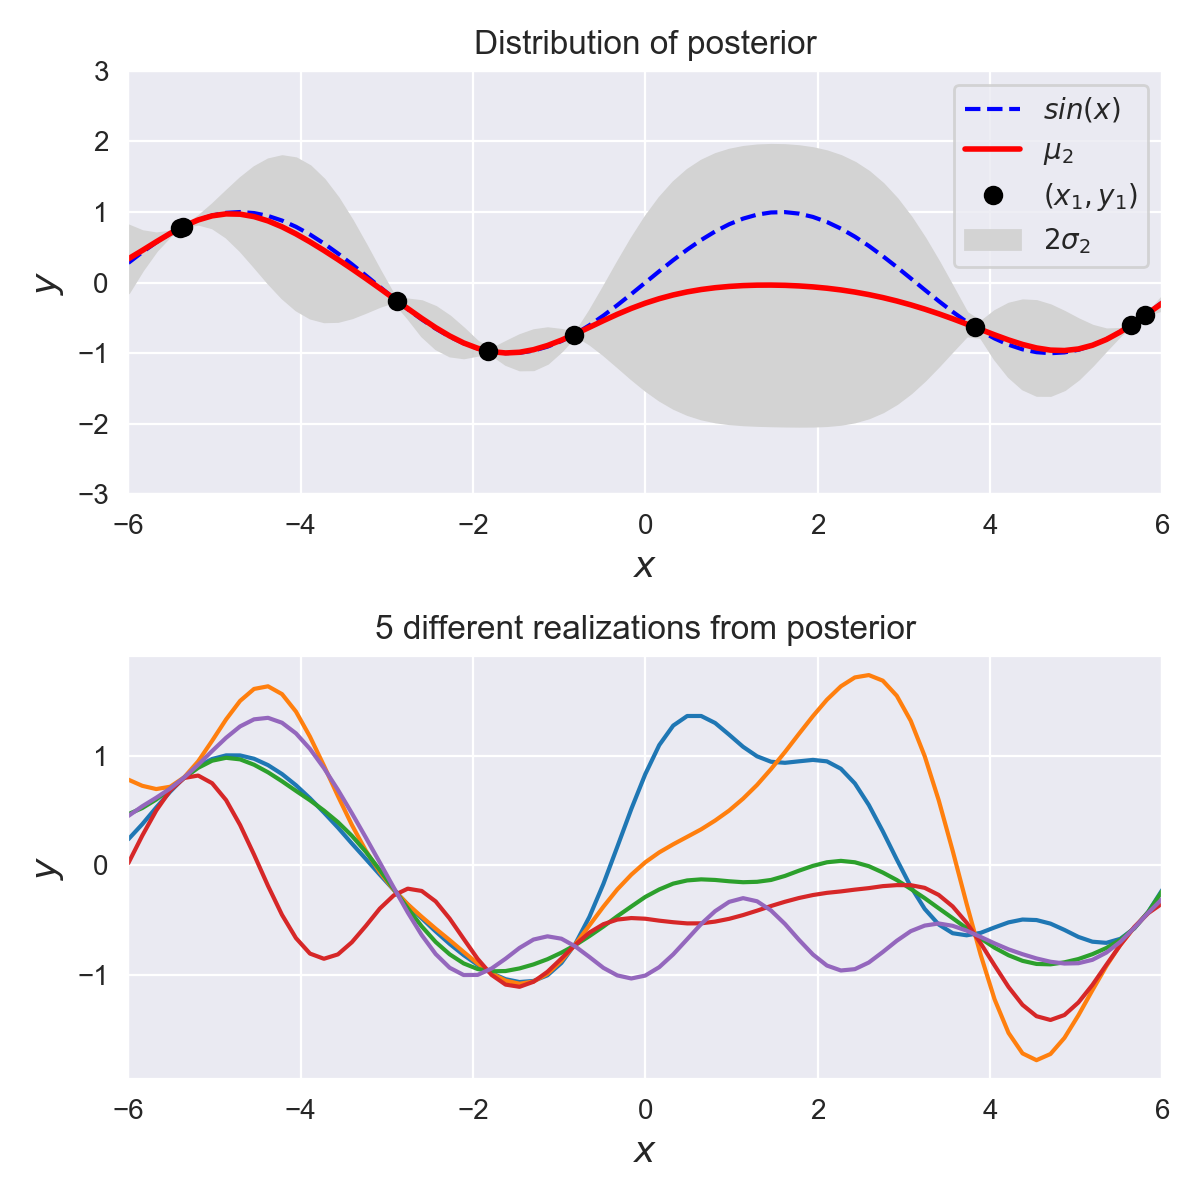

In [8]:
# Plot the postior distribution and some samples
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6,6))
# Plot the distribution of the function (mean, covariance)
ax1.plot(X2, f_sin(X2), 'b--', label='$sin(x)$')
ax1.fill_between(X2.flat, mean-2*std, mean+2*std, color='lightgrey', 
                 label='$2 \sigma_2$')
ax1.plot(X2, mean, 'r-', lw=2, label='$\mu_2$')
ax1.plot(X1, y1, 'ko', linewidth=2, label='$(x_1, y_1)$')
ax1.set_xlabel('$x$', fontsize=13)
ax1.set_ylabel('$y$', fontsize=13)
ax1.set_title('Distribution of posterior')
ax1.axis([domain[0], domain[1], -3, 3])
ax1.legend()
# Plot some samples from this function
ax2.plot(X2, y2, '-')
ax2.set_xlabel('$x$', fontsize=13)
ax2.set_ylabel('$y$', fontsize=13)
ax2.set_title('5 different realizations from posterior')
ax1.axis([domain[0], domain[1], -3, 3])
ax2.set_xlim([-6, 6])
plt.tight_layout()
plt.show()
#

### Noisy observations

The predictions made above assume that the observations $f(X_1) = \mathbf{y}_1$ come from a noiseless distribution. We can notice this in the plot above because the posterior variance becomes zero at the observations $(X_1,\mathbf{y}_1)$.
We can make predictions from noisy observations $f(X_1) = \mathbf{y}_1 + \epsilon$, by modelling the noise $\epsilon$ as Gaussian noise with variance $\sigma_\epsilon^2$.

This noise can be modelled by adding it to the covariance kernel of our observations:

$$
K_{11} = K(X_1,X_1) + \sigma_\epsilon^2 I
$$

Where $I$ is the identity matrix. Note that the noise only changes kernel values on the diagonal (white noise is independently distributed).

In [9]:
# Gaussian process posterior with noisy obeservations
def GP_noise(X1, y1, X2, kernel_func, noise):
    """
    Calculate the mean and covariance matrix for the points 
    X2 with unknown y2, based on the noisy observations 
    (y1, X1) and the prior kernel.
    """
    # Kernel of the noisy observations
    K11 = kernel_func(X1, X1) + noise * np.eye(n1)
    # Kernel of observations vs to-predict
    K12 = kernel_func(X1, X2)
    # solve
    solved = scipy.linalg.solve(
        K11, K12, assume_a='pos').T
    # Compute posterior mean
    mu2 = solved @ y1
    # Compute the posterior covariance
    K22 = kernel_func(X2, X2)
    S21 = K22 - (solved @ K12)
    return mu2, S21  # mean, covariance
    return mu2, S21

The code below calculates the posterior distribution of the previous 8 samples with added noise. Note in the plots that the variance $\sigma_2^2$ at the observations is no longer 0, and that the functions sampled don't necessarily have to go through these observational points anymore.

In [10]:
# Compute the posterior mean and covariance

noise = 0.2  # The variance of the noise
# Add noise to the samples we sampled previously
y1_noise = y1 + noise * np.random.randn(n1)

# Compute posterior mean and covariance
mean_noise, cov_noise = GP_noise(
    X1, y1_noise, X2, kernel_func, noise)
# Compute the standard deviation at the test points to be plotted
std = np.sqrt(np.diag(cov_noise))

# Draw some samples of the posterior
LS21 = np.linalg.cholesky(cov_noise + 1e-14*np.eye(n2))
y2 = mean.reshape(-1,1) + LS21.dot(np.random.normal(size=(n2,ny)))

<IPython.core.display.Javascript object>


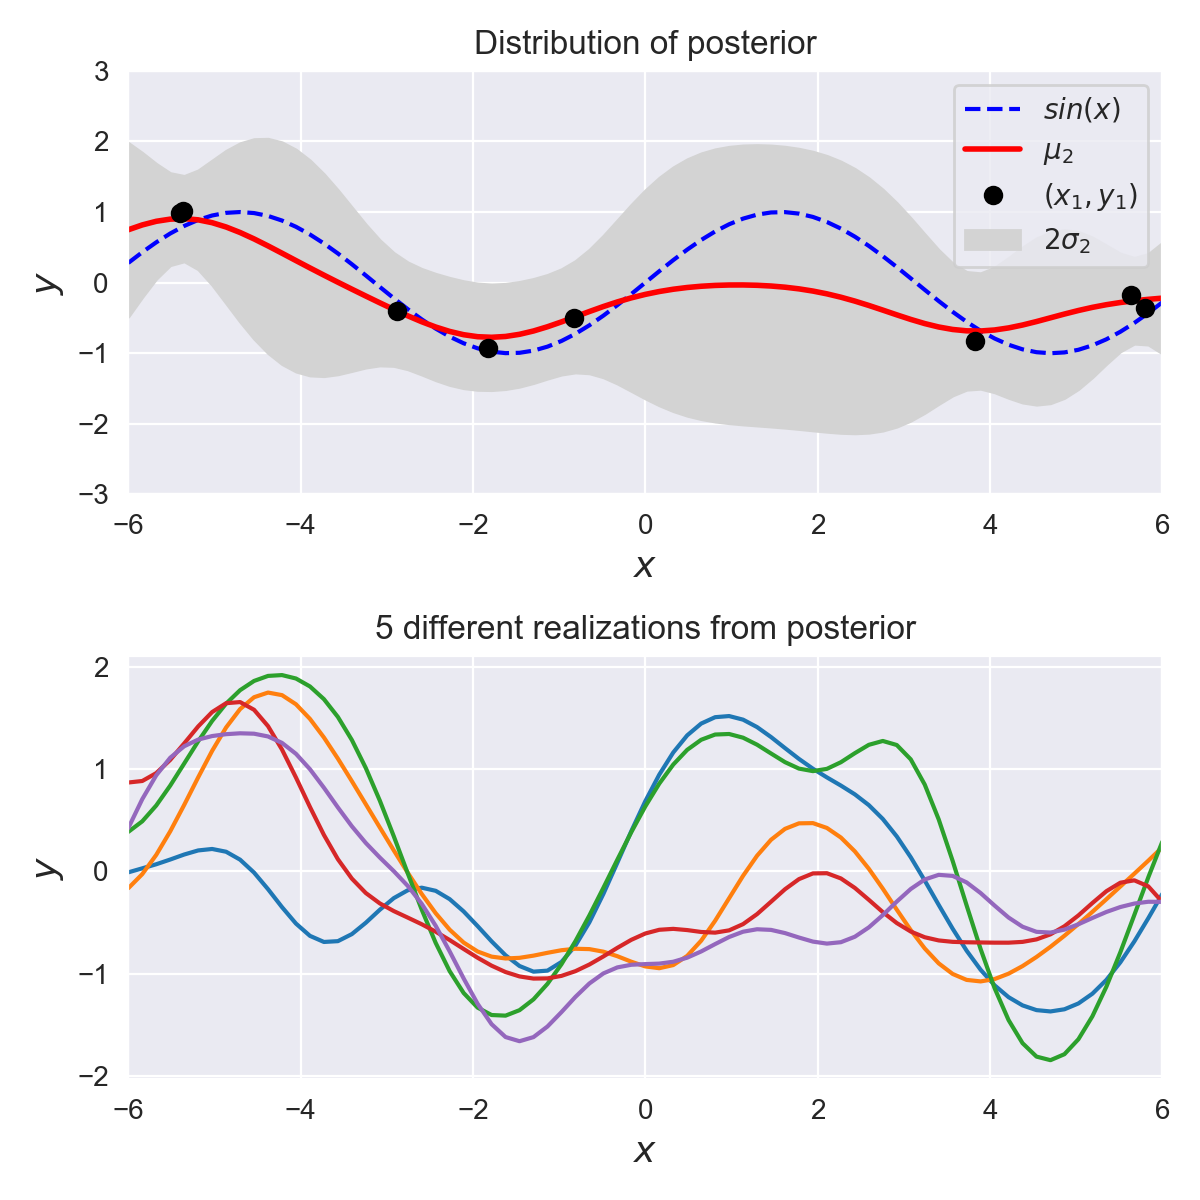

In [14]:
# Plot the postior distribution and some samples
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6,6))
# Plot the distribution of the function (mean, covariance)
ax1.plot(X2, f_sin(X2), 'b--', label='$sin(x)$')
ax1.fill_between(X2.flat, mean_noise-2*std, mean_noise+2*std, 
                 color='lightgrey', label='$2\sigma_2$')
ax1.plot(X2, mean_noise, 'r-', lw=2, label='$\mu_2$')
ax1.plot(X1, y1_noise, 'ko', linewidth=2, label='$(x_1, y_1)$')
ax1.set_xlabel('$x$', fontsize=13)
ax1.set_ylabel('$y$', fontsize=13)
ax1.set_title('Distribution of posterior')
ax1.axis([domain[0], domain[1], -3, 3])
ax1.legend()
# Plot some samples from this function
ax2.plot(X2, y2, '-')
ax2.set_xlabel('$x$', fontsize=13)
ax2.set_ylabel('$y$', fontsize=13)
ax2.set_title('5 different realizations from posterior')
ax1.axis([domain[0], domain[1], -3, 3])
ax2.set_xlim([-6, 6])
plt.tight_layout()
plt.show()
#

To summarise the post:

- A Gaussian process is a distribution over functions fully specified by a mean and covariance function.
- Every finite subset of a Gaussian Process is a Multivariate Gaussian.
- The posterior predictions of a Gaussian process are weighted averages of the observed variables where the weighting is based on the coveriance and mean functions.

In [12]:
# Versions used
print('Python: {}.{}.{}'.format(*sys.version_info[:3]))
print('numpy: {}'.format(np.__version__))
print('scipy: {}'.format(scipy.__version__))
print('matplotlib: {}'.format(matplotlib.__version__))
print('seaborn: {}'.format(sns.__version__))
#

Python: 3.7.0
numpy: 1.15.2
scipy: 1.1.0
matplotlib: 3.0.0
seaborn: 0.9.0


## Futher readings

1. [Introduction to Gaussian processes videolecture](https://www.youtube.com/watch?v=4vGiHC35j9s&list=PLE6Wd9FR--EdyJ5lbFl8UuGjecvVw66F6&index=8) by Nando de Freitas
2. [Gaussian Processes for Machine Learning](http://www.gaussianprocess.org/gpml/) by Carl Edward Rasmussen and Christopher K. I. Williams (Book covering Gaussian processe in detail, online version downloadable as pdf)




* http://blog.sigopt.com/post/130275376068/sigopt-fundamentals-intuition-behind-gaussian
* http://learning.eng.cam.ac.uk/carl/talks/gpnt06.pdf
* http://blog.sigopt.com/post/134931842613/sigopt-fundamentals-likelihood-for-gaussian
* http://blog.sigopt.com/post/134931028143/sigopt-in-depth-profile-likelihood-vs-kriging